## Homework 1 : Clasificvation of AI-generated and human-generated text from AI_Human.csv


---
> **Student ID:** 313831002


> **Student Name:** Pavan Kumar J | 柯奉煌

> **Course Name:** Recurrent Neural Networks

> **Instructor:** 黃仁竑 


### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import re
import string
from collections import Counter
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# For tokenization and stopword removal
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

# For progress bars during training
from tqdm import tqdm


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
print("Device:", device)

Device: cuda


### Load and Preprocess Data

In [3]:
df = pd.read_csv('./AI_Human.csv/AI_Human.csv')
df.head()

,text,generated
0,Cars. Cars have been around since they became ...,0.0
1,Transportation is a large necessity in most co...,0.0
2,"""America's love affair with it's vehicles seem...",0.0
3,How often do you ride in a car? Do you drive a...,0.0
4,Cars are a wonderful thing. They are perhaps o...,0.0


### Define cleaning functions

In [4]:
def remove_links(text):
    return re.sub(r'https?:\/\/\S+', '', text)

def remove_tags(text):
    return re.sub(r'<.*?>', '', text)

def remove_stopwords(text):
    stops = set(stopwords.words('english'))
    return " ".join([word for word in text.split() if word not in stops])

def tokenize_text(text):
    return word_tokenize(text)

def remove_punctuation(word):
    return "".join([char for char in word if char not in string.punctuation])


### --- Preprocessing Pipeline ---

### Lowercase text

In [5]:
df['clean_text'] = df['text'].str.lower()

### Remove links and HTML tags

In [6]:

# 
df['clean_text'] = df['clean_text'].apply(remove_links)
df['clean_text'] = df['clean_text'].apply(remove_tags)

### Remove stopwords

In [7]:
# 
df['clean_text'] = df['clean_text'].apply(remove_stopwords)

### Tokenize, remove punctuation from each token, then rejoin

In [8]:
# 
df['clean_text'] = df['clean_text'].apply(lambda x: " ".join([remove_punctuation(token) 
                                                               for token in tokenize_text(x)]))

In [9]:
# (Optional) For rapid testing use a small subset:
# df_sample = df.sample(frac=0.1, random_state=42).reset_index(drop=True)
print("Data sample shape:", df.shape)
print("Sample cleaned text:")
print(df['clean_text'].head())


Data sample shape: (487235, 3)
Sample cleaned text:
0    cars  cars around since became famous 1900s  h...
1    transportation large necessity countries world...
2     america s love affair vehicles seems cooling ...
3    often ride car  drive one motor vehicle work  ...
4    cars wonderful thing  perhaps one worlds great...
Name: clean_text, dtype: object


### Build Vocabulary and Numericalize Text

In [10]:
def simple_tokenizer(text):
    return text.split()

# Build vocabulary using cleaned text
counter = Counter()
for text in df['clean_text']:
    counter.update(simple_tokenizer(text))

# Reserve index 0 for <unk> and 1 for <pad>
vocab = {word: i+2 for i, (word, _) in enumerate(counter.items())}
vocab['<unk>'] = 0
vocab['<pad>'] = 1

print("Vocabulary size:", len(vocab))

# Function to convert text into a list of integers
def numericalize(text, vocab):
    return [vocab.get(word, vocab['<unk>']) for word in text.split()]


Vocabulary size: 277290


### Define Custom Dataset 

In [11]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, vocab):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # Convert text to numerical sequence
        seq = numericalize(self.texts[idx], self.vocab)
        label = self.labels[idx]
        return torch.tensor(seq, dtype=torch.long), torch.tensor(label, dtype=torch.float)

### Define Padding Collate Function

In [12]:
def pad_collate_fn(batch, pad_idx):
    texts, labels = zip(*batch)
    lengths = [len(text) for text in texts]
    max_len = max(lengths)
    padded_texts = torch.full((len(texts), max_len), pad_idx, dtype=torch.long)
    for i, text in enumerate(texts):
        padded_texts[i, :len(text)] = text
    return padded_texts, torch.tensor(labels, dtype=torch.float)


### Split Data and Create DataLoaders

In [13]:
X = df['clean_text'].values
y = df['generated'].values  # 0 for human, 1 for AI

# First split: train_temp (70%) and test (30%)
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
# Second split: train (80% of train_temp) and validation (20% of train_temp)
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.2, random_state=42, stratify=y_train_temp)

print("Training samples:", len(X_train))
print("Validation samples:", len(X_val))
print("Testing samples:", len(X_test))

# Create PyTorch Datasets
train_dataset = TextDataset(X_train.tolist(), y_train.tolist(), vocab)
val_dataset   = TextDataset(X_val.tolist(), y_val.tolist(), vocab)
test_dataset  = TextDataset(X_test.tolist(), y_test.tolist(), vocab)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          collate_fn=lambda batch: pad_collate_fn(batch, vocab['<pad>']))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                        collate_fn=lambda batch: pad_collate_fn(batch, vocab['<pad>']))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                         collate_fn=lambda batch: pad_collate_fn(batch, vocab['<pad>']))


Training samples: 272851
Validation samples: 68213
Testing samples: 146171


### Define Model Architectures

### LSTM Classifier

In [14]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, pad_idx):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text):
        # text: [batch, seq_len]
        embedded = self.embedding(text)  # [batch, seq_len, embedding_dim]
        _, (hidden, _) = self.lstm(embedded)  # hidden: [1, batch, hidden_dim]
        return self.fc(hidden.squeeze(0))  # [batch, output_dim]


### Hybrid LSTM-CNN Model (combining LSTM and CNN features)

In [15]:
class LSTM_CNNClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, pad_idx,
                 filter_sizes=[3,4,5], num_filters=[100,100,100]):
        super(LSTM_CNNClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        # LSTM branch
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        # CNN branch
        self.conv1d_list = nn.ModuleList([
            nn.Conv1d(in_channels=embedding_dim,
                      out_channels=num_filters[i],
                      kernel_size=filter_sizes[i])
            for i in range(len(filter_sizes))
        ])
        # Fully connected layers (combining both branches)
        self.fc = nn.Linear(hidden_dim + sum(num_filters), output_dim)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, text):
        # text: [batch, seq_len]
        embedded = self.embedding(text)  # [batch, seq_len, embedding_dim]
        # LSTM branch
        _, (hidden, _) = self.lstm(embedded)  # hidden: [1, batch, hidden_dim]
        lstm_out = hidden.squeeze(0)  # [batch, hidden_dim]
        # CNN branch: need to permute to [batch, embedding_dim, seq_len]
        conv_input = embedded.permute(0, 2, 1)
        conv_outs = [F.relu(conv(conv_input)) for conv in self.conv1d_list]
        # Apply max pooling over the time dimension for each conv output
        pooled = [torch.max(conv_out, dim=2)[0] for conv_out in conv_outs]
        cnn_out = torch.cat(pooled, dim=1)  # [batch, sum(num_filters)]
        # Concatenate LSTM and CNN outputs and apply dropout
        combined = torch.cat([lstm_out, cnn_out], dim=1)
        combined = self.dropout(combined)
        return self.fc(combined).squeeze(1)



### Choose which model to use: 'LSTM' or 'LSTM_CNN'

In [16]:
model_choice = 'LSTM'  
#model_choice = 'LSTM_CNN' # change to 'LSTM_CNN' to use the hybrid model

### Hyperparameters

In [17]:
embedding_dim = 100
hidden_dim = 256
output_dim = 1  # Binary classification (logit output)
vocab_size = len(vocab)
pad_idx = vocab['<pad>']

if model_choice == 'LSTM':
    model = LSTMClassifier(vocab_size, embedding_dim, hidden_dim, output_dim, pad_idx)
elif model_choice == 'LSTM_CNN':
    model = LSTM_CNNClassifier(vocab_size, embedding_dim, hidden_dim, output_dim, pad_idx,
                               filter_sizes=[3,4,5], num_filters=[100,100,100])
else:
    raise ValueError("Invalid model_choice. Please choose 'LSTM' or 'LSTM_CNN'.")

model = model.to(device)
print(model)


LSTMClassifier(
  (embedding): Embedding(277290, 100, padding_idx=1)
  (lstm): LSTM(100, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)


### Define Training and Evaluation Functions

In [18]:
criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = torch.optim.Adam(model.parameters())

def train_epoch(model, loader, optimizer, criterion):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0
    for texts, labels in tqdm(loader, desc="Training", leave=False):
        texts, labels = texts.to(device), labels.to(device)
        optimizer.zero_grad()
        predictions = model(texts).squeeze(1)
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        # Compute accuracy for the batch
        preds = torch.round(torch.sigmoid(predictions))
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return epoch_loss / len(loader), correct / total

def evaluate_epoch(model, loader, criterion):
    model.eval()
    epoch_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for texts, labels in tqdm(loader, desc="Evaluating", leave=False):
            texts, labels = texts.to(device), labels.to(device)
            predictions = model(texts).squeeze(1)
            loss = criterion(predictions, labels)
            epoch_loss += loss.item()
            preds = torch.round(torch.sigmoid(predictions))
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return epoch_loss / len(loader), correct / total


### Training Loop

In [19]:
num_epochs = 20
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate_epoch(model, val_loader, criterion)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"  Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc*100:.2f}%")
    print(f"  Val   Loss: {val_loss:.4f}, Val   Accuracy: {val_acc*100:.2f}%")


Epoch 1/20:
  Train Loss: 0.1412, Train Accuracy: 93.84%
  Val   Loss: 0.0272, Val   Accuracy: 99.23%


Epoch 2/20:
  Train Loss: 0.0592, Train Accuracy: 98.08%
  Val   Loss: 0.0286, Val   Accuracy: 99.20%


Epoch 3/20:
  Train Loss: 0.0276, Train Accuracy: 99.25%
  Val   Loss: 0.0145, Val   Accuracy: 99.62%


Epoch 4/20:
  Train Loss: 0.0103, Train Accuracy: 99.72%
  Val   Loss: 0.0117, Val   Accuracy: 99.65%


Epoch 5/20:
  Train Loss: 0.0063, Train Accuracy: 99.83%
  Val   Loss: 0.0069, Val   Accuracy: 99.83%


Epoch 6/20:
  Train Loss: 0.0043, Train Accuracy: 99.89%
  Val   Loss: 0.0055, Val   Accuracy: 99.86%


Epoch 7/20:
  Train Loss: 0.0052, Train Accuracy: 99.86%
  Val   Loss: 0.0084, Val   Accuracy: 99.77%


Epoch 8/20:
  Train Loss: 0.0026, Train Accuracy: 99.93%
  Val   Loss: 0.0047, Val   Accuracy: 99.88%


Epoch 9/20:
  Train Loss: 0.0018, Train Accuracy: 99.95%
  Val   Loss: 0.0102, Val   Accuracy: 99.78%


Epoch 10/20:
  Train Loss: 0.0014, Train Accuracy: 99.96%
  Val   Loss: 0.0050, Val   Accuracy: 99.88%


Epoch 11/20:
  Train Loss: 0.0010, Train Accuracy: 99.97%
  Val   Loss: 0.0045, Val   Accuracy: 99.90%


Epoch 12/20:
  Train Loss: 0.0008, Train Accuracy: 99.98%
  Val   Loss: 0.0038, Val   Accuracy: 99.91%


Epoch 13/20:
  Train Loss: 0.0008, Train Accuracy: 99.97%
  Val   Loss: 0.0076, Val   Accuracy: 99.84%


Epoch 14/20:
  Train Loss: 0.0005, Train Accuracy: 99.98%
  Val   Loss: 0.0047, Val   Accuracy: 99.91%


Epoch 15/20:
  Train Loss: 0.0007, Train Accuracy: 99.98%
  Val   Loss: 0.0042, Val   Accuracy: 99.91%


Epoch 16/20:
  Train Loss: 0.0005, Train Accuracy: 99.98%
  Val   Loss: 0.0040, Val   Accuracy: 99.91%


Epoch 17/20:
  Train Loss: 0.0005, Train Accuracy: 99.99%
  Val   Loss: 0.0043, Val   Accuracy: 99.92%


Epoch 18/20:
  Train Loss: 0.0003, Train Accuracy: 99.99%
  Val   Loss: 0.0064, Val   Accuracy: 99.89%


Epoch 19/20:
  Train Loss: 0.0003, Train Accuracy: 99.99%
  Val   Loss: 0.0044, Val   Accuracy: 99.91%


Epoch 20/20:
  Train Loss: 0.0004, Train Accuracy: 99.99%
  Val   Loss: 0.0046, Val   Accuracy: 99.92%


### Plotting Training History

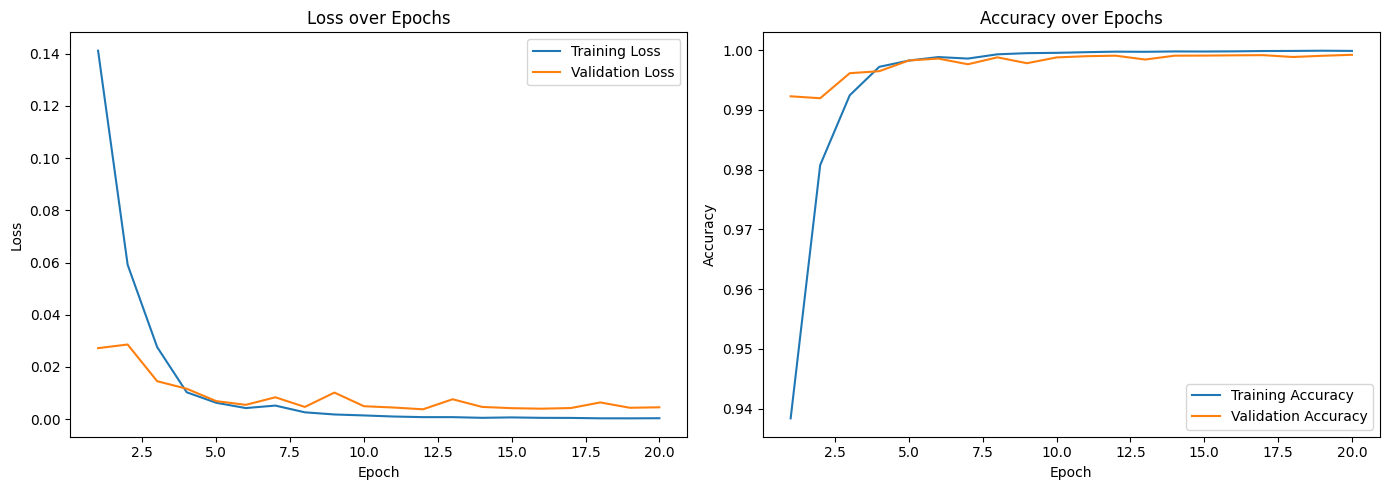

In [20]:
epochs_range = range(1, num_epochs+1)

plt.figure(figsize=(14, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Training Loss")
plt.plot(epochs_range, val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label="Training Accuracy")
plt.plot(epochs_range, val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.show()


### Evaluate on Test Data

In [21]:
test_loss, test_acc = evaluate_epoch(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc*100:.2f}%")


Test Loss: 0.0059, Test Accuracy: 99.90%


### Generate predictions for confusion matrix

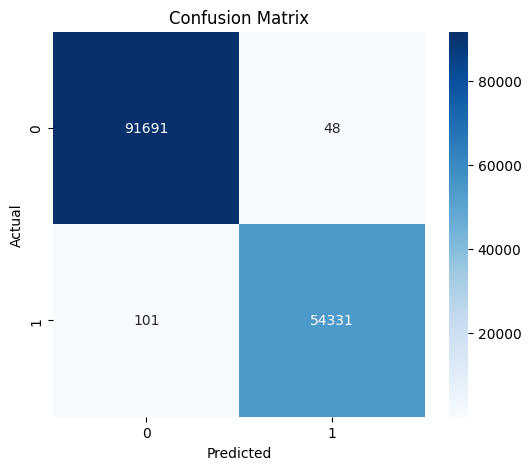

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     91739
         1.0       1.00      1.00      1.00     54432

    accuracy                           1.00    146171
   macro avg       1.00      1.00      1.00    146171
weighted avg       1.00      1.00      1.00    146171



In [22]:
model.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for texts, labels in test_loader:
        texts = texts.to(device)
        predictions = model(texts).squeeze(1)
        preds = torch.round(torch.sigmoid(predictions)).cpu().numpy()
        all_preds.extend(preds)
        all_targets.extend(labels.numpy())

# Confusion Matrix
cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(all_targets, all_preds))


## Using LSTM_CNN

In [23]:
#model_choice = 'LSTM'  
model_choice = 'LSTM_CNN' # change to 'LSTM_CNN' to use the hybrid model

In [24]:
embedding_dim = 100
hidden_dim = 256
output_dim = 1  # Binary classification (logit output)
vocab_size = len(vocab)
pad_idx = vocab['<pad>']

if model_choice == 'LSTM':
    model = LSTMClassifier(vocab_size, embedding_dim, hidden_dim, output_dim, pad_idx)
elif model_choice == 'LSTM_CNN':
    model = LSTM_CNNClassifier(vocab_size, embedding_dim, hidden_dim, output_dim, pad_idx,
                               filter_sizes=[3,4,5], num_filters=[100,100,100])
else:
    raise ValueError("Invalid model_choice. Please choose 'LSTM' or 'LSTM_CNN'.")

model = model.to(device)
print(model)


LSTM_CNNClassifier(
  (embedding): Embedding(277290, 100, padding_idx=1)
  (lstm): LSTM(100, 256, batch_first=True)
  (conv1d_list): ModuleList(
    (0): Conv1d(100, 100, kernel_size=(3,), stride=(1,))
    (1): Conv1d(100, 100, kernel_size=(4,), stride=(1,))
    (2): Conv1d(100, 100, kernel_size=(5,), stride=(1,))
  )
  (fc): Linear(in_features=556, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [25]:
criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = torch.optim.Adam(model.parameters())

def train_epoch(model, loader, optimizer, criterion):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0
    for texts, labels in tqdm(loader, desc="Training", leave=False):
        texts, labels = texts.to(device), labels.to(device)
        optimizer.zero_grad()
        predictions = model(texts)
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        # Compute accuracy for the batch
        preds = torch.round(torch.sigmoid(predictions))
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return epoch_loss / len(loader), correct / total

def evaluate_epoch(model, loader, criterion):
    model.eval()
    epoch_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for texts, labels in tqdm(loader, desc="Evaluating", leave=False):
            texts, labels = texts.to(device), labels.to(device)
            predictions = model(texts)
            loss = criterion(predictions, labels)
            epoch_loss += loss.item()
            preds = torch.round(torch.sigmoid(predictions))
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return epoch_loss / len(loader), correct / total


In [26]:
num_epochs = 20
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate_epoch(model, val_loader, criterion)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"  Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc*100:.2f}%")
    print(f"  Val   Loss: {val_loss:.4f}, Val   Accuracy: {val_acc*100:.2f}%")


Epoch 1/20:
  Train Loss: 0.0769, Train Accuracy: 97.17%
  Val   Loss: 0.0120, Val   Accuracy: 99.65%


Epoch 2/20:
  Train Loss: 0.0224, Train Accuracy: 99.33%
  Val   Loss: 0.0116, Val   Accuracy: 99.69%


Epoch 3/20:
  Train Loss: 0.0152, Train Accuracy: 99.59%
  Val   Loss: 0.0088, Val   Accuracy: 99.80%


Epoch 4/20:
  Train Loss: 0.0118, Train Accuracy: 99.72%
  Val   Loss: 0.0164, Val   Accuracy: 99.76%


Epoch 5/20:
  Train Loss: 0.0105, Train Accuracy: 99.77%
  Val   Loss: 0.0077, Val   Accuracy: 99.86%


Epoch 6/20:
  Train Loss: 0.0090, Train Accuracy: 99.82%
  Val   Loss: 0.0091, Val   Accuracy: 99.86%


Epoch 7/20:
  Train Loss: 0.0088, Train Accuracy: 99.85%
  Val   Loss: 0.0099, Val   Accuracy: 99.86%


Epoch 8/20:
  Train Loss: 0.0091, Train Accuracy: 99.85%
  Val   Loss: 0.0162, Val   Accuracy: 99.77%


Epoch 9/20:
  Train Loss: 0.0080, Train Accuracy: 99.87%
  Val   Loss: 0.0128, Val   Accuracy: 99.88%


Epoch 10/20:
  Train Loss: 0.0080, Train Accuracy: 99.90%
  Val   Loss: 0.0265, Val   Accuracy: 99.77%


Epoch 11/20:
  Train Loss: 0.0074, Train Accuracy: 99.91%
  Val   Loss: 0.0177, Val   Accuracy: 99.83%


Epoch 12/20:
  Train Loss: 0.0078, Train Accuracy: 99.91%
  Val   Loss: 0.0175, Val   Accuracy: 99.85%


Epoch 13/20:
  Train Loss: 0.0081, Train Accuracy: 99.91%
  Val   Loss: 0.0206, Val   Accuracy: 99.86%


Epoch 14/20:
  Train Loss: 0.0062, Train Accuracy: 99.93%
  Val   Loss: 0.0220, Val   Accuracy: 99.83%


Epoch 15/20:
  Train Loss: 0.0070, Train Accuracy: 99.92%
  Val   Loss: 0.0212, Val   Accuracy: 99.87%


Epoch 16/20:
  Train Loss: 0.0074, Train Accuracy: 99.93%
  Val   Loss: 0.0275, Val   Accuracy: 99.83%


Epoch 17/20:
  Train Loss: 0.0072, Train Accuracy: 99.93%
  Val   Loss: 0.0234, Val   Accuracy: 99.88%


Epoch 18/20:
  Train Loss: 0.0069, Train Accuracy: 99.94%
  Val   Loss: 0.0175, Val   Accuracy: 99.88%


Epoch 19/20:
  Train Loss: 0.0066, Train Accuracy: 99.95%
  Val   Loss: 0.0199, Val   Accuracy: 99.87%


Epoch 20/20:
  Train Loss: 0.0076, Train Accuracy: 99.93%
  Val   Loss: 0.0238, Val   Accuracy: 99.87%


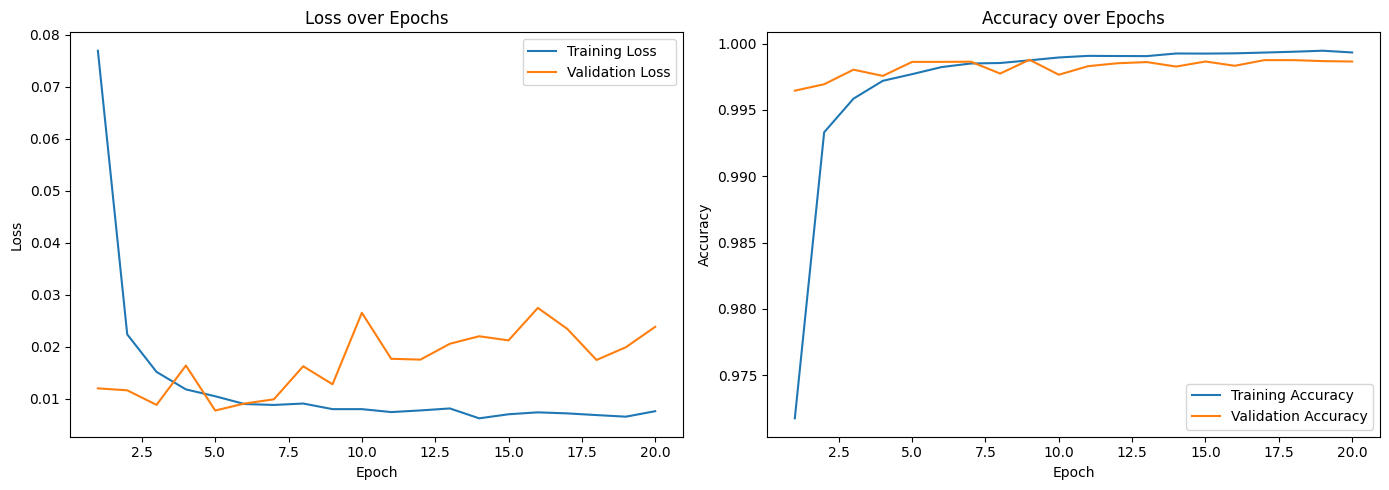

In [27]:
# Cell 9: Plotting Training History
epochs_range = range(1, num_epochs+1)

plt.figure(figsize=(14, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Training Loss")
plt.plot(epochs_range, val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label="Training Accuracy")
plt.plot(epochs_range, val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.show()


In [28]:
### Evaluate on Test Data
test_loss, test_acc = evaluate_epoch(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc*100:.2f}%")

Test Loss: 0.0248, Test Accuracy: 99.87%


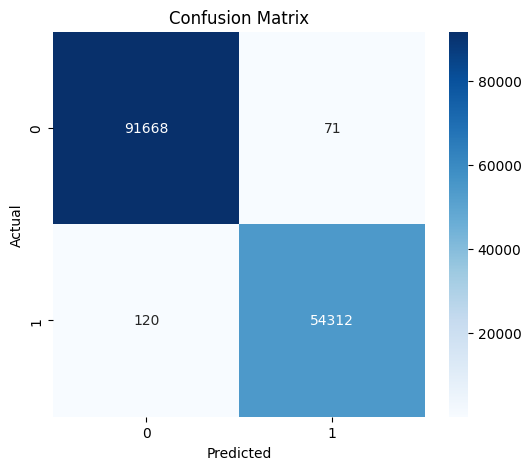

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     91739
         1.0       1.00      1.00      1.00     54432

    accuracy                           1.00    146171
   macro avg       1.00      1.00      1.00    146171
weighted avg       1.00      1.00      1.00    146171



In [29]:
# Generate predictions for confusion matrix
model.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for texts, labels in test_loader:
        texts = texts.to(device)
        predictions = model(texts)
        preds = torch.round(torch.sigmoid(predictions)).cpu().numpy()
        all_preds.extend(preds)
        all_targets.extend(labels.numpy())

# Confusion Matrix
cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(all_targets, all_preds))
